# FMCA Samplet GP Filtering on SimOcean Data

We can use samplets for kernel filtering, that is we represent the kernel in a samplet basis and pick the diagonal subblock containing the largest diagonal elements. This way, we can even deal with highly ill conditioned kernels
and arbitrary data sizes.

### first import modules

In [68]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import scipy
import scipy.sparse.linalg as sla
import time
import FMCA
import pandas  as pd 
from sklearn.model_selection import train_test_split


### Create data points
(We force NumPy to use column major arrays for performance reasons)

In [69]:
# Read the data base Input-Output 
df = pd.read_excel('Case5_1st_launch_WingsConvCoeffs_Info.xlsx')
# show the database
df.head()

,#nWings,aws,awa,alpha0,alpha1,alpha2,alpha3,center0,center1,center2,...,Cy2Var,Cm2Mean,Cm2Var,Cx3Mean,Cx3Var,Cy3Mean,Cy3Var,Cm3Mean,Cm3Var,Unnamed: 47
0,4,14.3,30.1,-5,-10,-10,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.006390,-0.541107,0.001642,0.956189,0.001994,2.630745,0.009438,-0.446254,0.002265,NOTCONVERGED
1,4,14.3,30.1,-3,-10,-10,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000005,-0.548886,0.000001,1.036123,0.000004,2.774566,0.000005,-0.461669,0.000002,CONVERGED
2,4,14.3,30.1,-1,-10,-10,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000006,-0.547075,0.000002,1.045209,0.000003,2.789169,0.000005,-0.462784,0.000001,CONVERGED
3,4,14.3,30.1,1,-10,-10,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000010,-0.544396,0.000003,1.056299,0.000009,2.803353,0.000017,-0.463607,0.000004,CONVERGED
4,4,14.3,30.1,3,-10,-10,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000007,-0.541173,0.000002,1.068542,0.000003,2.817156,0.000004,-0.464311,0.000001,CONVERGED


In [70]:
# fill the data with selected keys 
data = np.vstack([df["alpha0"].to_numpy().astype(np.float64),
                                df["alpha1"].to_numpy().astype(np.float64),
                                df["Cy0Mean"].to_numpy().astype(np.float64)])
# split data in trial and test
pts = data[:2,:]
values = data[2,:]

pts_train, pts_test, y_train, y_test = train_test_split(
    pts.T,  values.T , test_size=0.33, random_state=42)

pts_train = np.asfortranarray(pts_train.T)
pts_test = np.asfortranarray(pts_test.T)




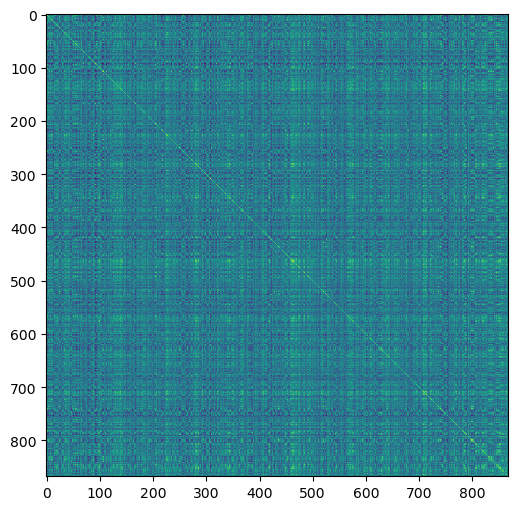

In [71]:
# reorder the input with col-major and compute the covariance with Exponential Kernel

cov = FMCA.CovarianceKernel("EXPONENTIAL", 10.)
cov_eval = cov.eval(pts_train,pts_train)
fig = plt.figure(figsize=(6, 6))
plt.imshow(cov_eval)
plt.show()
#fig.savefig("covariance.png")


print bounding box   min =[ -5. -10.] and max = [5. 0.] 
time tree setup:              0.08235359191894531 sec.
time kernel compression:      0.18033313751220703 sec.
1005.5380624372069


C:\Users\david\AppData\Local\Temp\ipykernel_12972\1392177939.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


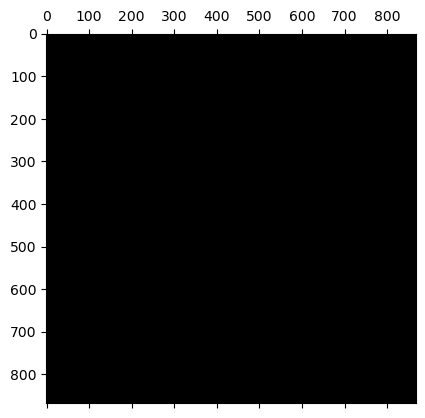

In [67]:
dtilde = 10 # vanish momement 

start = time.time()

ST = FMCA.SampletTree(pts_train, dtilde)
FMCA.sampletTreeStatistics(ST, pts_train)
print("print bounding box   min ={} and max = {} ".format(np.min(pts_train,axis=1), np.max(pts_train,axis=1)))

stop = time.time()
print('time tree setup:             ', stop - start, 'sec.')
start = time.time()
eta = 1 
SKC = FMCA.SampletKernelCompressor(ST, cov, pts_train, eta, 1e-10)
stop = time.time()
print('time kernel compression:     ', stop - start, 'sec.')
# return matrix and create lower triangular part
K = SKC.matrix()
K = K + scipy.sparse.triu(K, k=1).transpose()
K = K.todense()
K_ = FMCA.inverseSampletTransform(ST,K)
K_ = FMCA.inverseSampletTransform(ST,K_.T)
print(np.linalg.norm(K? -cov_eval[ST.indices(),ST.indices()]))
fig, ax = plt.subplots()
ax.spy(K_)

fig.show()
#fig.savefig("sparse_covariance_{:.2e}.png".format(eta))


## filter the kernel matrix
in Samplet basis, we now filter the relevant frequencies by simple diagonal pivoting (!!!) the remaining number of coefficients is steered by the parameter number_of_coefficients

filtered kernel error:        2.918285190270489e-17
condition number:             inf


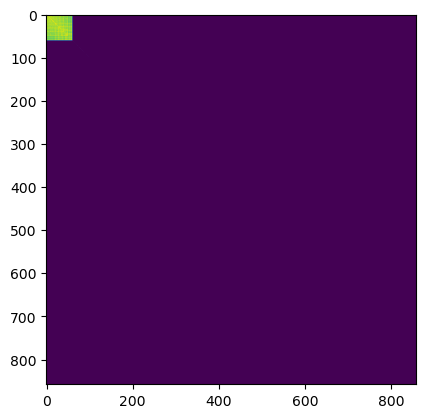

In [55]:
number_of_coefficients = K.shape[0]-10
idx = np.sort((-K.diagonal()).argsort()[:number_of_coefficients])
Ksmall = K[np.ix_(idx,idx)]
N = K.shape[0]
Kemb = scipy.sparse.csr_matrix((N,N))
Kemb[np.ix_(idx,idx)] = Ksmall
print('filtered kernel error:       ', sla.norm(K-Kemb)/sla.norm(K))
print('condition number:            ', la.cond(Ksmall.todense()))
fig, ax = plt.subplots()

plt.imshow(np.log(np.abs(Ksmall.todense())+1e-16))
plt.show()


## now filter data and solve the linear system

In [49]:
# Reorder the output and input based on ST indices .
output = y_train
y = output[ST.indices()]
spts = pts_train[:,ST.indices()]
# Transform y in new coordinate 
Ty = FMCA.sampletTransform(ST, y)

Tysmall = Ty[idx,:]


In [50]:
Talpha = la.solve(Ksmall.todense(), Tysmall)
r = Tysmall - Ksmall @ Talpha
print('residual:                    ', la.norm(r)/la.norm(Tysmall))
Talphaemb = np.zeros(Ty.shape)
Talphaemb[idx,:] = Talpha
alpha = FMCA.inverseSampletTransform(ST, Talphaemb)


residual:                     1.23697223468807e-17


## evaluate kernel interpolant on Train

In [51]:

spts = pts_train[:,ST.indices()]
Keval = cov.eval(spts, spts)

r = y_train[ST.indices()].reshape(-1,1) - Keval @ alpha

# least square interpolation:  y - K alpha 

print('residual:                    ', la.norm(r)/la.norm(y_train))

residual:                     0.11928399965192685


## evaluate kernel interpolant on Test dataset

In [ ]:
Keval = cov.eval(pts_test, spts)
Keval_test  = cov.eval(pts_test, pts_test)
mu = Keval @ alpha 


#std = Keval_test -  Keval @ alpha 


r = y_test.reshape(-1,1) - Keval @ alpha

# least square interpolation:  y - K alpha 

print('residual:                    ', la.norm(r)/la.norm(y_test))